In [19]:
import os
import time
from collections import deque
from tqdm import tqdm

import gym_pendrogone

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate


from utils import PlanarQuadrotorDynamicsWithInvertedPendulum

In [20]:
class Args():
    def __init__(self):
        self.algo = 'ppo'
        self.lr = 1e-3
        self.eps = 1e-5
        self.alpha = 0.99
        self.gamma = 0.95
        self.use_gae = False
        self.gae_lambda = 0.95
        self.entropy_coef = 0.01
        self.clip_param = 0.4
        self.ppo_epoch = 30
        self.num_mini_batch = 100
        self.value_loss_coef = 0.5
        self.max_grad_norm = 0.5
        self.seed = 1
        self.num_processes = 1
        self.num_steps = 500
        self.log_interval = 10
        self.save_interval = 100
        self.eval_interval = None # Not supported because not using wrapper env structs
        self.num_env_steps = 1e6
        self.env_name = 'Pendrogone-v0'
        self.log_dir = '/tmp/gym/'
        self.save_dir = './trained_models/'
        self.no_cuda = False
        self.use_proper_time_limits = False
        self.recurrent_policy = False
        self.use_linear_lr_decay = False
        
        self.cuda = not self.no_cuda and torch.cuda.is_available()
        
        assert self.algo in ['a2c', 'ppo', 'acktr']
        if self.recurrent_policy:
            assert self.algo in ['a2c', 'ppo'], \
                'Recurrent policy is not implemented for ACKTR'

args = Args()

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.cuda and torch.cuda.is_available() and args.cuda_deterministic:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
        
log_dir = os.path.expanduser(args.log_dir)
eval_log_dir = log_dir + "_eval"
utils.cleanup_log_dir(log_dir)
utils.cleanup_log_dir(eval_log_dir)

torch.set_num_threads(1)
device = torch.device("cuda:0" if args.cuda else "cpu")

In [21]:
# envs = make_vec_envs(args.env_name, args.seed, args.num_processes, args.gamma, args.log_dir, device, False)

# Not using wrapper envs allow code to run without errors, but can't use provided evaluation code
env = gym.make('Pendrogone-v0')

In [22]:
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space,
    base_kwargs={'recurrent': args.recurrent_policy})
actor_critic.to(device)

Policy(
  (base): MLPBase(
    (actor): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (critic): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (critic_linear): Linear(in_features=64, out_features=1, bias=True)
  )
  (dist): DiagGaussian(
    (fc_mean): Linear(in_features=64, out_features=2, bias=True)
    (logstd): AddBias()
  )
)

In [23]:
agent = algo.A2C_ACKTR(
    actor_critic,
    args.value_loss_coef,
    args.entropy_coef,
    lr=args.lr,
    eps=args.eps,
    alpha=args.alpha,
    max_grad_norm=args.max_grad_norm)
# agent = algo.PPO(
#                  actor_critic,
#                  args.clip_param,
#                  args.ppo_epoch,
#                  args.num_mini_batch,
#                  args.value_loss_coef,
#                  args.entropy_coef,
#                  lr=args.lr,
#                  eps=args.eps,
#                  max_grad_norm=args.max_grad_norm,
#                  use_clipped_value_loss=True)

In [24]:
rollouts = RolloutStorage(args.num_steps, args.num_processes,
                              env.observation_space.shape, env.action_space,
                              actor_critic.recurrent_hidden_state_size)

obs = env.reset()
obs = torch.from_numpy(obs).float().to(device)
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

losses = []

In [25]:
start = time.time()
num_updates = int(args.num_env_steps) // args.num_steps // args.num_processes
with tqdm(range(num_updates)) as pbar:
    for j in pbar:

        if args.use_linear_lr_decay:
            # decrease learning rate linearly
            utils.update_linear_schedule(
                agent.optimizer, j, num_updates,
                agent.optimizer.lr if args.algo == "acktr" else args.lr)

        for step in range(args.num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Observe reward and next obs
            action = action[0]
            obs, reward, done, info = env.step(action)
            reward, done, infos = np.array([reward]), [done], [info]
            obs = torch.from_numpy(obs).float().to(device)
            reward = torch.from_numpy(reward).unsqueeze(dim=1).float()

#             for info in infos:
#                 if 'episode' in info.keys():
#                     episode_rewards.append(info['episode']['r'])
            episode_rewards.append(reward[0,0].numpy())

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)

        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, args.use_gae, args.gamma,
                                 args.gae_lambda, args.use_proper_time_limits)

        value_loss, action_loss, dist_entropy = agent.update(rollouts)
        losses.append((value_loss, action_loss, dist_entropy))

        rollouts.after_update()

        # save for every interval-th episode or for the last epoch
        if (j % args.save_interval == 0
                or j == num_updates - 1) and args.save_dir != "":
            save_path = os.path.join(args.save_dir, args.algo)
            try:
                os.makedirs(save_path)
            except OSError:
                pass

            torch.save([
                actor_critic,
                getattr(utils.get_vec_normalize(env), 'obs_rms', None)
            ], os.path.join(save_path, args.env_name + ".pt"))

        if j % args.log_interval == 0 and len(episode_rewards) > 1:
            total_num_steps = (j + 1) * args.num_processes * args.num_steps
            end = time.time()
            pbar.set_description("FPS {}: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}"
                .format(int(total_num_steps / (end - start)),
                        np.mean(episode_rewards), np.median(episode_rewards),
                        np.min(episode_rewards), np.max(episode_rewards)))
#             print(
#                 "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
#                 .format(j, total_num_steps,
#                         int(total_num_steps / (end - start)),
#                         len(episode_rewards), np.mean(episode_rewards),
#                         np.median(episode_rewards), np.min(episode_rewards),
#                         np.max(episode_rewards), dist_entropy, value_loss,
#                         action_loss))

        if (args.eval_interval is not None and len(episode_rewards) > 1
                and j % args.eval_interval == 0):
            obs_rms = utils.get_vec_normalize(env).obs_rms
            evaluate(actor_critic, obs_rms, args.env_name, args.seed,
                     args.num_processes, eval_log_dir, device)

FPS 2362: mean/median reward -3733846.8/-3733845.8, min/max reward -3735333.0/-3732363.5:   3%|▎         | 54/2000 [00:11<06:56,  4.67it/s]


KeyboardInterrupt: 

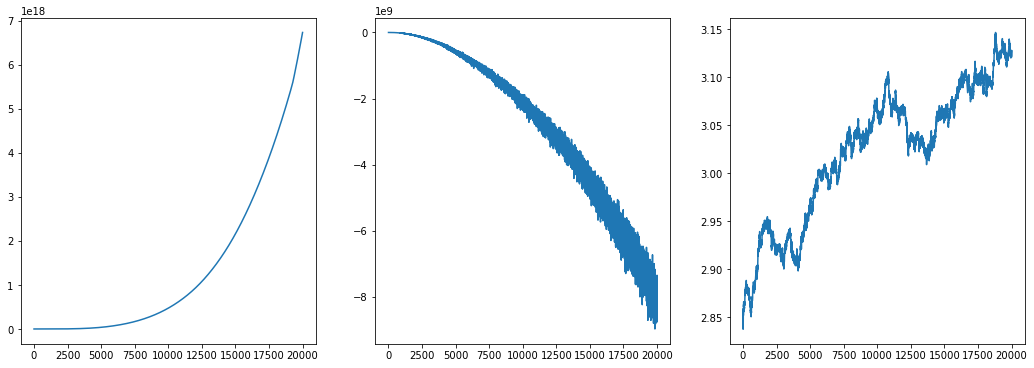

In [ ]:
losses = np.array(losses)
_, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].plot(losses[:,0], label="value_loss")
ax[1].plot(losses[:,1], label="action_loss")
ax[2].plot(losses[:,2], label="dist_entropy")
# plt.legend()
plt.show()

In [ ]:
def evaluate(actor_critic, obs_rms, env_name, seed, num_processes, eval_log_dir,
             device):
    # eval_envs = make_vec_envs(env_name, seed + num_processes, num_processes,
    #                               None, eval_log_dir, device, True)

    eval_envs = gym.make('Pendrogone-v0')

    vec_norm = utils.get_vec_normalize(eval_envs)
    if vec_norm is not None:
        vec_norm.eval()
        vec_norm.obs_rms = obs_rms

    eval_episode_rewards = []

    obs = eval_envs.reset()
    eval_recurrent_hidden_states = torch.zeros(
        num_processes, actor_critic.recurrent_hidden_state_size, device=device)
    eval_masks = torch.zeros(num_processes, 1, device=device)

    while len(eval_episode_rewards) < 10:
        with torch.no_grad():
            _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                obs,
                eval_recurrent_hidden_states,
                eval_masks,
                deterministic=True)

        # Obser reward and next obs
        obs, _, done, infos = eval_envs.step(action)

        eval_masks = torch.tensor(
            [[0.0] if done_ else [1.0] for done_ in done],
            dtype=torch.float32,
            device=device)

        for info in infos:
            if 'episode' in info.keys():
                eval_episode_rewards.append(info['episode']['r'])

    eval_envs.close()

    print(" Evaluation using {} episodes: mean reward {:.5f}\n".format(
        len(eval_episode_rewards), np.mean(eval_episode_rewards)))

In [ ]:
obs_rms = utils.get_vec_normalize(env).obs_rms
evaluate(actor_critic, obs_rms, args.env_name, args.seed,
                     args.num_processes, eval_log_dir, device)

AttributeError: 'NoneType' object has no attribute 'obs_rms'

In [ ]:
eval_env = gym.make('Pendrogone-v0')

In [ ]:
frames = []
rewards = []

recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size)
masks = torch.zeros(1, 1)
obs = eval_env.reset()
obs = torch.from_numpy(obs).float().to(device)

for _ in range(1000):
    
    with torch.no_grad():
        value, action, _, recurrent_hidden_states = actor_critic.act(
            obs, recurrent_hidden_states, masks, deterministic=True)
    
    # torch.Size([1, 2, 1, 2])
    action = action[0][0][0]
    obs, reward, done, _ = eval_env.step(action)
    obs = torch.from_numpy(obs).float().to(device)
    
    masks.fill_(0.0 if done else 1.0)
    # print(obs)
    frames.append(eval_env.render(mode = 'rgb_array'))
    rewards.append(reward)

In [ ]:
plt.figure()
plt.plot(np.cumsum(rewards))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from IPython.display import HTML

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=25)
    anim = HTML(anim.to_html5_video())
    # display(display_animation(anim, default_mode='loop'))

In [ ]:
display_frames_as_gif(frames)

In [ ]:
episode_rewards